In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import scipy as s
from IPython.display import display
import matplotlib.pyplot as plt

# Table of Contents <a name="contents"></a>
- [**1. Introduction**](#introduction)
    - [1.1. A Generative Model for Skill](#a_generative_model_for_skill)
    - [1.2. Outcome given Skills](#outcome_given_skills)
    - [1.3. Skills given Outcome, and the Evidence](#skills_given_outcome_and_the_evidence)
    - [1.4. Computing the Conditionals](#computing_the_conditionals)
- [**2. Load the Data**](#load_the_data)
- [**3. Gibbs Rank**](#gibbs_rank)
    - [3.1. Integration of an Intractable Posterior](#integration_of_an_intractable_posterior)
    - [3.2. Gibbs Sampling](#gibbs_sampling)
    - [3.3. Gibbs Sampling for TrueSkill](#gibbs_sampling_for_trueskill)
    - [3.4. Implementation](#implementation)
- [**4. Message Passing**](#message_passing)


# 1. Introduction <a name="introduction"></a>

Ranking systems have many different applications, however most common ones are poor as they rely on arbitrary conventions which lead to poor proformance. In general, they try to answer they question **What is the probability that player 1 defeats player 2?**. In order to determine this probabilistically, there are a number of things to consider:

- Considers who you played against.
- Must be robust against players who have not played against eachother.
- Give a good estimate at any point in the season.
- Take into account performance inconsistancy.

Therefore, what we want to infer is the player's **skill**, $w$. These skills must be comparable (i.e. a player with a higher skill must be more likely to win), and as such we want to do a probabilstic inference of a player's skill and be able to compute the probability of a game's outcome.

## 1.1. A generative model for skill <a name="a_generative_model_for_skill"></a>
[Back to Top](#contents)

A summary of a generative model for game outcomes can be defined as:

1. **Skills** Take two players with known skills, $$w_i \in \mathbb{R}$$
2. **Skill Difference**: $$s = w_1 - w_2$$
3. **Performance Difference**: Add noise ($n \sim \mathcal{N}(0, 1))$ to account for performance inconsistance: $$t = s + n$$
4. **Game outcome** is given by $y=sign(t)$:
    - $y = +1$ means player 1 wins
    - $y = -1$ means player 2 wins

![GenerativeModel](Figures/GenerativeModel.png)

The graph above shows part of the directed graph for the TrueSkill model. This encapsulates all of the conditional dependencies described above, and allows the joint distribution to be written as:

$$p(w_1, w_2, s_{12}, t_{12} | y_{12}) = \frac{p(w_1, w_2, s_{12}, t_{12}, y_{12})}{p(y)} = \frac{p(w_1)p(w_2)p(s_{12}|w_1, w_2)p(t_{12}|s_{12})p(y_{12}|t_{12})}{p(y)}$$

Note that this graphical model is described as "head-to-head" because the S nodes are at the head of at least two directed connections. A rule in graphical models is that if any "head-to-head" node, or any of its descendents, are observed, the path between parents nodes becomes "unblocked". I.e. the skills become dependent on eachother - which makes sense as we cannot determine one players skill without playing them against another.

The joint distribution given above is only a very small section of the whole joint distribution, which is almost circular in its dependencies (i.e. there is also an $s_{13}$ and an $s_{1,103}$, and so on - a different s for every game played).

We derive the probabilities above in subsequent sections. The aim of this notebook is to derive the marginal distributions $p(w)$ for all players.

## 1.2. Outcome given Skills <a name="outcome_given_skills"></a>
[Back to Top](#contents)
    
Therefore we can work out the probability that player 1 wins given the players skills':

$$p(y| w_1, w_2) = \int \int p(y|t) p(t|s) p(s | w_1, w_2) dsdt$$
$$ = \int p(y|t) p(t|w_1, w_2) dt$$
$$ = \int^{+\infty}_{-\infty} \delta(y - sign(t)) \mathcal{N}(t; w_1 - w_2, 1) dt$$
$$ = \int^{+\infty}_{-\infty} \delta(1 - sign(yt)) \mathcal{N}(yt; y(w_1 - w_2), 1) dt $$
set z = yt and note the change in limits and dt:
$$ = \int^{+y\infty}_{-y\infty} \delta(1 - sign(z)) \mathcal{N}(z; y(w_1 - w_2), 1) y dz $$
$$ = \int^{+\infty}_{-\infty} \delta(1 -sign(z)) \mathcal{N}(z; y(w_1 - w_2), 1) dz $$
And rearrange the limits:
$$ = \int^{+\infty}_{0} \mathcal{N}(z; y(w_1 - w_2), 1) dz $$
using $x = y(w_1-w_2) - z$
$$ = \int^{y(w_1 - w_2)}_{-\infty} \mathcal{N}(x; 0, 1) dx $$
$$ = \Phi(y(w_1 - w_2))$$

where $\Phi(a)$ is the gaussian c.d.f, or the *probit* function.

For the probability of player 1 winning, we simply use $p(y=1| w_1, w_2) = p(t>0| w_1, w_2) = \Phi(w_1 - w_2)$

![PerformanceDifference](Figures/PerformanceDifference.jpg)

## 1.3. Skills Given Outcome, and the Evidence <a name="skills_given_outcome_and_the_evidence"></a>
[Back to Top](#contents)

$$p(w_1, w_2 | y) = \frac{Priors \times Likelihood}{Evidence}$$
<br>
$$ = \frac{p(w_1)p(w_2) \times p(y|w_1, w_2)}{\int \int p(w_1)p(w_2) \times p(y|w_1, w_2) dw_1 dw_2}$$
<br>
$$ = \frac{\mathcal{N}(w_1; \mu_1, \sigma_1^2) \mathcal{N}(w_2; \mu_2, \sigma_2^2) \times \Phi(y(w_1 - w_2))}{\int \int \mathcal{N}(w_1; \mu_1, \sigma_1^2) \mathcal{N}(w_2; \mu_2, \sigma_2^2) \times \Phi(y(w_1 - w_2)) dw_1 dw_2}$$

The joint posterior over skills does not have a closed form as the probit function is not closed. Additionally, $w_1$ and $w_2$ have become correlated due to the priors and therefore does not factorise, nor is it a gaussian density function.

Fortunately, the evidence does have a closed form:

$$p(y) = \int \int \mathcal{N}(w_1; \mu_1, \sigma_1^2) \mathcal{N}(w_2; \mu_2, \sigma_2^2) \times \Phi(y(w_1 - w_2)) dw_1 dw_2 = \Phi \bigg(\frac{y(\mu_1 - \mu_2)}{\sqrt{1 + \sigma_1^2 + \sigma_2^2}} \bigg)$$

This is effectively a smoother version of the likelihood as we are using mean skills of each player, and normalising over their variances.

## 1.4. Computing the Conditionals <a name="computing_the_conditionals"></a>
[Back to Top](#contents)

For notation we have have $g = \{1, ..., G\}$ games where $I_g$ is the id of player 1, and $J_g$ is the id of player 1. The outcome of game g is:

$$y_g = \bigg{\{} \begin{array}{c} +1 \; if \; I_g \; wins \\ -1 \; if \; J_g \; wins \end{array}$$

Note also that the vector of skills is $\boldsymbol{w} = [w_1, ..., w_d]^T$, (d=107 players) and the vector of performance differences is $\boldsymbol{t} = [t_1, ..., t_G]^T$.

In **True Skill** the joint distribution $p(w_{1:d}, t_{1:G})$ is intractable. However, the two conditionals are tractable and easily derived to be:

- **Performance given skill difference**: $p(t_g | w_{I_g}, w_{J_g}, y_g) \propto \delta(y_g - sign(t_g)) \mathcal{N}(t_g;  w_{I_g} - w_{J_g}, 1)$
- **Skills given performances**: $p( \boldsymbol{w} | \boldsymbol{t}, \boldsymbol{y}) = p( \boldsymbol{w} | \boldsymbol{t}) \propto p(\boldsymbol {w}; \boldsymbol{\mu}_0, \Sigma_0) \prod_{g=1}^G \mathcal{N}(\boldsymbol{w}; \boldsymbol{\mu}_g, \Sigma_g)$

In order to calculate these, we can take the performance difference directly from the derivation of the evidence:

$$p(t | w_1, w_2, y) = p(y|t) p(t|w_1, w_2) = \delta(y - sign(t)) \mathcal{N}(t; w_1 - w_2, 1) dt$$

and similarly, we note that the priors for skill are $p(w_i) = \mathcal{N}(w_i | u_i, \sigma_i^2) \implies p(\boldsymbol{w}) = \prod_{i=1}^d p(w_i) = \mathcal{N}(\boldsymbol{w} ; \boldsymbol{\mu}_0, \Sigma_0)$. Thus,

$$p( \boldsymbol{w} | \boldsymbol{t}) = \frac{p(\boldsymbol{w})p(\boldsymbol{t}| \boldsymbol{w})}{p(\boldsymbol{t})} \propto p(\boldsymbol{w}) \prod_{g=1}^G p(t_g | w_{I_g}, w_{J_g}) = \mathcal{N}(\boldsymbol{w} ; \boldsymbol{\mu}_0, \Sigma_0) \prod_{g=1}^G \mathcal{N}(\boldsymbol{w}; \boldsymbol{\mu}_g, \Sigma_g)
$$

# 2. Load the Data <a name="load_the_data"></a>
[Back to Top](#contents)

In [3]:
import scipy.io
mat = scipy.io.loadmat('tennis_data.mat')

In [4]:
PLAYERS = pd.DataFrame(mat['W'], columns=['name']).applymap(lambda x: x[0])  # remove the list around each players name
GAMES = pd.DataFrame(mat['G']-1, columns=['winner', 'loser'])  # -1 because player num starts from 1 in matlab
display(PLAYERS.head(), GAMES.head())
display(len(PLAYERS), len(GAMES))

,name
0,Rafael-Nadal
1,Juan-Monaco
2,Juan-Martin-Del-Potro
3,Mardy-Fish
4,Roger-Federer


,winner,loser
0,0,1
1,0,2
2,0,2
3,0,2
4,0,2


107

1801

# 3. Gibbs Rank <a name="gibbs_rank"></a>

## 3.1. Integration of an Intractable Posterior <a name="integration_of_an_intractable_posterior"></a>
[Back to Top](#contents)

The basis of Monte-Carlo approximation is:
$$\mathbb{E}_{p(x)} \big[ \Phi(x) \big] \approx \hat{\Phi} = \frac{1}{T} \sum^t_{\tau = 1} \Phi(x^{(\tau)}), \text{  where } x^{(\tau)} \sim p(x)$$

Note that $x^{(\tau)}$ is the $\tau$th d-dimensional sample from the distribution p(x), which is analytically intractable (and typically d>>1).

This is infact an unbiased estimate, with $Var[\hat{\Phi}] = \frac{Var[\Phi]}{T}$. Note $Var[\Phi] = \int (\Phi(x) - \mathbb{E}[\Phi])^2 p(x) dx$. Note that this is independent of dimension d, of x.


How do we generate samples from p(x)? If the distribution has a standard form then we could generate independent samples, however, it is often difficult to sample from this joint distribution if it is within a high dimensional space (the curse of dimensionality). In order to get around this we can use **Gibbs Sampling**, which uses a Markov Chain to generate dependent samples from the desired distribution:

$$x_i' \sim  p(x_i | x_{1, 2, ..., i-1, i+1, ..., d})$$

## 3.2. Gibbs Sampling <a name="gibbs_sampling"></a>
[Back to Top](#contents)

Gibbs sampling assumes that we know the forms of the joint and conditional distributions. Given that $p(x, y) \propto p(x|y)$, we can thus sample from the conditional distributions. E.g. A number of experiments, k, are performed where we flip a coin n times (unknown). The coin is biased such that $p(heads) = \theta$.

- $n \sim U(5, 8)$
- $\theta \sim U(0, 1) = beta(1, 1)$

This gives us a sequence with the number of heads that were thrown: $X = (x_1, x_2, .., x_k)$. We are aiming to find $p(n, \theta | X) \propto p(X | n, \theta)p(n, \theta) = Zp(X | n, \theta)$. 

$$p(n, \theta | X) \propto \prod^k_{i=1} C^n_{x_i} \theta^{x_i} (1-\theta)^{n-x_i}$$
$$= \theta^{\sum+_{i=1}^k x_i}(1-\theta)^{\sum_{i=1}^k n-x_i} \prod_{i=1}^k  C^n_{x_i}$$
$$\theta^k\hat{x}(1-\theta)^{k(n-\hat{x})} \prod_{i=1}^k  C^n_{x_i}$$

Above is the joint probability upto a constant of proportionality. Next we need to find the conditionals, which we can do by simply splitting the above into $f_1(n)f_2(\theta)$.

$$p(\theta |n, X) \propto \theta^k\hat{x}(1-\theta)^{k(n-\hat{x})} = beta(k\hat{x}+1, k(n-\hat{x})+1)$$
$$p(n |\theta, X) \propto (1-\theta)^{kn}\prod_{i=1}^k  C^n_{x_i}$$

Note that there is no "nice" form for $p(n | \theta, X)$ here. But what we can do, is we know $n \in \{5, 6, 7, 8\}$, so we can use these values and sum them up to get a categorical distribution by normalising with them.

Gibbs sampling here then works simply by choosing some random starting point and then iteratively sampling from each of these two conditionals.

## 3.3. Gibbs Sampling for TrueSkill <a name="gibbs_sampling_for_trueskill"></a>
[Back to Top](#contents)

For **our problem**, we have 107 different players, and hence are sampling from 107 different conditional distributions for thier skills. Consider the distribution $p(x) = p(x_{1:d})$. The gibbs sampling algorithm is as follows:


> 1. Initialise $\{x_i : i = 1, .., d\}$
> 2. For $\tau = 1, ..., T$: <br>
    > &nbsp;&nbsp;&nbsp;&nbsp; For $i = 1, ..., d$: <br>
        > &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $x_{i}^{\tau+1} \sim p(x_i|x_{\backslash i}^{(\tau)})$
        
**Try over-relaxation?**

![GibbsSampling](Figures/GibbsSampling.jpg)

Above is an illustration of Gibbs sampmling by alternate updates of two variables, whose distribution is a correlated GAussian. The step size is govened by the standard deviation of the  <span style="color:green">condiditional distribution</span>, and is O(l), leading to slow progression in the direction of elongation of the <span style="color:red">joint distribution</span>. The number of steps needed to obtain an independent sample from the distribution is $O((\frac{L}{l})^2)$. I.e. **Strong correlations slow down gibbs sampling**.

In **True Skill** the joint distribution $p(w_{1:d}, t_{1:G})$ is intractable. However, the two conditionals are tractable and have already been derived to be:

- **Performance given skill difference**: $p(t_g | w_{I_g}, w_{J_g}, y_g) = \frac{p(y|t) p(t|w_1, w_2)}{p(y)} \propto \delta(y_g - sign(t_g)) \mathcal{N}(t_g;  w_{I_g} - w_{J_g}, 1)$
- **Skills given performances**: $p( \boldsymbol{w} | \boldsymbol{t}, \boldsymbol{y}) = p( \boldsymbol{w} | \boldsymbol{t}) \propto p(\boldsymbol{w}) \prod_{g=1}^G p(t_g | w_{I_g}, w_{J_g})  =  p(\boldsymbol {w}; \boldsymbol{\mu}_0, \Sigma_0) \prod_{g=1}^G \mathcal{N}(\boldsymbol{w}; \boldsymbol{\mu}_g, \Sigma_g)$

We can describe the two above distributions in more detail:

#### For the conditional posterior of skills (skills given performances) we get:

$$p(t_g|w_{I_g}, w_{J_g}) = \mathcal{N}(t_g; (w_{I_g} - w_{J_g}), 1) \propto exp(-\frac{1}{2}(t_g-(w_{I_g} - w_{J_g}))^2 )$$

renaming $t_g = \mu_1 - \mu_2$

$$\propto exp(-\frac{1}{2}((w_{I_g} - \mu_1) - ( w_{J_g} - \mu_2) )^2 )$$

$$ \propto exp \bigg( -\frac{1}{2} 
\left[\begin{array}{c} w_{I_g} - \mu_1 \\ w_{J_g} - \mu_2 \end{array}\right]
\left[\begin{array}{cc} 1 & -1 \\ -1 & 1 \end{array}\right]
\left[\begin{array}{c} w_{I_g} - \mu_1 \\ w_{J_g} - \mu_2 \end{array}\right] \bigg)
$$

Recall that when multiplying gaussians, the precisions add up and the means weighted by the precisions also add up:

- $\Sigma_c^{-1} = \Sigma_a^{-1} + \Sigma_b^{-1}$
- $\mu_c = \Sigma_c(\Sigma_a^{-1}\mu_a +  \Sigma_b^{-1} \mu_b)$

Thus:

$$p(\boldsymbol {w}; \boldsymbol{\mu}_0, \Sigma_0) \prod_{g=1}^G \mathcal{N}(\boldsymbol{w}; \boldsymbol{\mu}_g, \Sigma_g) = \mathcal{N}(\boldsymbol{w}; \mu, \Sigma)$$

Where each game precision, $\Sigma_g^{-1}$ contains only 4 non-zero entries, the full precisions and means are:

- $\Sigma^{-1} = \Sigma_0^{-1} + \sum_{g=1}^G \Sigma_g^{-1}  = \Sigma_0^{-1} + \tilde{\Sigma}^{-1}$
- $\mu = \Sigma(\Sigma_0^{-1}\mu_0 + \sum_{g=1}^G \Sigma_g^{-1}\mu_g) = \Sigma(\Sigma_0^{-1}\mu_0 + \tilde{\mu})$

defining these further:

$$\tilde{\mu}_i = \sum_{g=1}^G t_g(\delta(i-I_g) - \delta(i-J_g))$$


$$ [ \tilde{\Sigma}^{-1} ]_{ij}  = \bigg\{  \begin{array}{c} \sum_{g=1}^G \delta(i-I_g) + \delta(i-J_g) \; \; \; for \; i = j \\ \sum_{g=1}^G \delta(i-I_g)\delta(j-J_g) + \delta(i-J_g)\delta(j-I_g) \; \; \; for \; i \neq j  \end{array} $$

The conditional skills can be jointly sampled directly using the cholesky factorization.

#### For the conditional posterior of the performances (performance given skill difference), 

we get a truncated gaussian that needs no further analysis, however the question becomes how do we sample from it? The inverse transformation method, or rejection sampling are both possibilities.

## 3.4. Implementation <a name="implementation"></a>
[Back to Top](#contents)

In [5]:
def gibbs_sampler(total_iters, players=PLAYERS, games=GAMES):
    num_players, num_games = len(players), len(games)
    
    skill_samples = np.zeros(shape=(num_players, total_iters))
    prior_skill_vars = 0.5*np.ones(shape=(num_players))
    skills = np.zeros(shape=(num_players))
    
    for i in range(total_iters):
        ##### 1. SAMPLE p(performance_diffs | skills, outcomes)
        p_diffs = np.zeros(shape=(num_games))  # one peformance diff for each game
        for g in range(num_games):
            skill_diff = skills[games.at[g, 'winner']] - skills[games.at[g, 'loser']]
            
            # rejection sampling. Only positive performance diffs are accepted
            p_diffs[g] = skill_diff + np.random.randn()
            while p_diffs[g] < 0:
                p_diffs[g] = skill_diff + np.random.randn()
                   
        ##### 2. SAMPLE p(skills | performance_diffs)
        skills_mean = np.zeros(shape=(num_players))
        for p in range(num_players):
            skills_mean[p] = np.dot(p_diffs, ((games['winner'] - p) == 0).astype(np.int32) - ((games['loser'] - p) == 0).astype(np.int32))            
        
        skills_precision = np.zeros(shape=(num_players, num_players))
        for g in range(num_games):
            skills_precision[games.at[g, 'winner'], games.at[g, 'winner']] += 1
            skills_precision[games.at[g, 'loser'], games.at[g, 'loser']] += 1
            skills_precision[games.at[g, 'winner'], games.at[g, 'loser']] -= 1
            skills_precision[games.at[g, 'loser'], games.at[g, 'winner']] -= 1 
        skills_precision = np.diag(1.0 /prior_skill_vars) + skills_precision
        
        # cholesky decomposition of the precision matrix so we can sample from a multivariate gaussian
        chol = scipy.linalg.cho_factor(skills_precision) # (107x107 upper tri chol decomp, bower=false)
        mu = scipy.linalg.cho_solve(c_and_lower=chol, b=skills_mean, check_finite=False) # solve C.mu=b, mu=107x0
        sample = mu + scipy.linalg.solve_triangular(chol[0], np.random.randn(num_players, 1), check_finite=False).flatten() # 107x107
        
        skill_samples[:, i] = sample
        
    return skill_samples

In [6]:
%%time
skill_samples = gibbs_sampler(1100)
skill_samples = pd.DataFrame(data=skill_samples.T, columns=PLAYERS['name'])
display(skill_samples.describe()) # there are tot_iters rows and each row is a person

name,Rafael-Nadal,Juan-Monaco,Juan-Martin-Del-Potro,Mardy-Fish,Roger-Federer,Jo-Wilfried-Tsonga,Guillermo-Garcia-Lopez,Florian-Mayer,Milos-Raonic,Santiago-Giraldo,...,Juan-Sebastian-Cabal,Colin-Fleming,Santiago-Gonzalez,Marc-Lopez,Rohan-Bopanna,Michael-Kohlmann,Simon-Aspelin,Mikhail-Elgin,Robert-Lindstedt,Jean-Julien-Rojer
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,...,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,0.766720,0.148996,0.438059,0.325265,0.764852,0.462228,-0.171172,0.298390,0.235084,-0.012638,...,-0.532143,-0.207541,0.031671,-0.108240,-0.394746,-0.403069,-0.237297,-0.626111,-0.185964,-0.444167
std,0.153757,0.182495,0.164519,0.171706,0.159190,0.157105,0.201560,0.167741,0.199908,0.188817,...,0.555764,0.613788,0.530922,0.542743,0.459271,0.625530,0.596869,0.393588,0.611365,0.639229
min,0.252446,-0.448460,-0.180885,-0.231634,0.231858,-0.053540,-0.855386,-0.181887,-0.504877,-0.532068,...,-2.316391,-2.385836,-1.556304,-1.955026,-1.646451,-2.859589,-2.131838,-1.855749,-1.986028,-2.523427
25%,0.663004,0.021271,0.334476,0.211207,0.657281,0.364600,-0.297985,0.186866,0.103709,-0.143965,...,-0.916053,-0.622549,-0.318847,-0.475604,-0.722028,-0.808254,-0.635746,-0.894107,-0.597092,-0.874426
50%,0.762627,0.149453,0.436668,0.325844,0.770081,0.461680,-0.170079,0.289428,0.236238,-0.017419,...,-0.527144,-0.198111,0.037787,-0.120613,-0.393050,-0.396003,-0.221067,-0.625570,-0.178143,-0.454239
75%,0.863142,0.278424,0.549107,0.438736,0.872565,0.569253,-0.036855,0.414308,0.365841,0.117356,...,-0.118894,0.221088,0.395706,0.246969,-0.066142,0.005048,0.176786,-0.362518,0.224996,-0.027509
max,1.342297,0.815419,0.959269,0.877255,1.249033,1.061943,0.495676,0.834130,0.860028,0.592565,...,1.180956,1.672668,2.168258,1.778640,0.828458,1.597845,1.637560,0.834449,1.719522,1.671245


Wall time: 2min 13s


## 3.5. Iterations and Autocorrelation <a name="iterations_and_autocorrelation"></a>
[Back to Top](#contents)

In [8]:
def plot_skill_vs_iter(skill_samples, players):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 4))  # preferred to plt.plot
    
    # use pandas to plot things... it's better than matplotlib
    skill_samples[players].plot(ax=ax, alpha=0.5)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Player Skill')

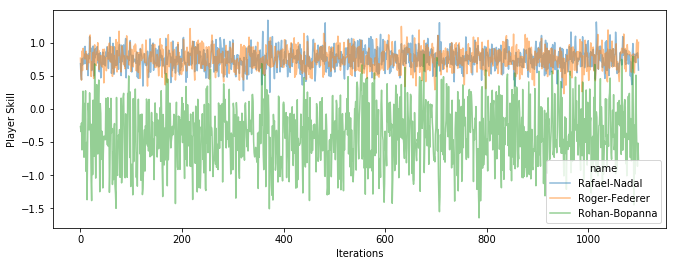

In [9]:
player_names=['Rafael-Nadal', 'Roger-Federer', 'Rohan-Bopanna']
plot_skill_vs_iter(skill_samples, player_names)

In [10]:
def plot_autocorrelations(skill_samples, players):
    max_lag=10    
    autocor = pd.DataFrame(columns=players, index=range(max_lag))
    
    for p in players:
        for i in range(max_lag):
            autocor.at[i, p] = pd.Series.autocorr(pd.Series(skill_samples[p].values), lag=i)
     
    autocor.plot()

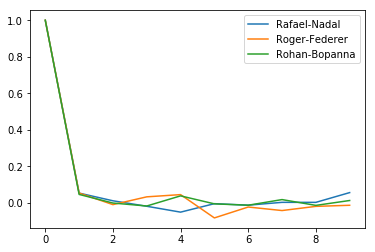

In [11]:
plot_autocorrelations(skill_samples, player_names)

In [237]:
def gaussian_distribution(x, mu, s):
    exponent = -0.5*((x-mu)/s)**2
    Z = (s * np.sqrt(2*np.pi))
    return np.exp(exponent) / Z

# 4. Message Passing <a name="message_passing"></a>

## 4.1. Inference and Factor Graphs
[Back to Top](#contents)

Probability distributions often have conditional independence, and therefore, can be written in graphical form. Computing marginals of said distribution can be made much more efficient by taking advantage of the graphical model, simply by rearranging the order of summations and multiplications required.

We can write any joint distribution over a set of variables in the form of a product of factors:

$$p(\boldsymbol{x}) = \prod_s f_s(\boldsymbol{x}_s)$$

where $\boldsymbol{x}_s$ denotes a subset of the variables. Each factor $f_s$ is a function of this set of variables. For example consider the graph:

![FactorGraph](Figures/FactorGraphExample.PNG)

This has a factorisation of

$$p(\boldsymbol{x}) = f_a(x_1, x_2)f_b(x_1, x_2)f_c(x_2, x_3)f_d(x_3)$$

We can convert a directed graph to a factor graph by simply creating variable
nodes in the factor graph corresponding to the nodes of the directed graph, and then
create factor nodes corresponding to the conditional distributions, and then finally
add the appropriate links. There can be multiple factor graphs all of which
correspond to the same directed graph.

![FactorGraph2](Figures/FactorGraphExample2.PNG)

The directed graph here corresponds to the factorisation:

$$p(x_1, x_2, x_3) = p(x_1)p(x_2)p(x_3|x_1, x_2)$$

And the factor graphs have factors equal to:
$$b) \;\; f(x_1, x_2, x_3) = p(x_1)p(x_2)p(x_3|x_1, x_2)$$
$$c) \;\; f_a(x_1) = p(x_1), \; f_b(x_2) = p(x_2), \; f_c(x_1, x_2, x_3) = p(x_3|x_1, x_2)$$

In TrueSkill, the factor graph that is relevent to the directed graph given in section 1.1. is

![TrueSkillFactorGraph](Figures/FactorGraph.JPG)

## 4.2. The Sum-Product Algorithm
[Back to Top](#contents)


Note that each message comprises a set of K values, one for each choice of x_n, and so the product of two messages should be interpreted as the point-wise multiplication of the elements of the two messages to give another set of K values.

Note that each message has passed once in each direction across each link in the graph, and that the normalisation constant Z need only be evaluated once (using any convenient note).

If some nodes in the graph are observed, then the corresponding vaariables are simply clamped to their observed values and there is no summation.

## 4.3. The Sum-Product Algorithm
[Back to Top](#contents)

## 4.4. Message Passing in TrueSkill
[Back to Top](#contents)